# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. We'll go through the main steps of initializing the model, running it, and performing budget allocation.



## 1. Import Required Libraries and Create Synthetic Data

First, let's import the necessary libraries and create some synthetic data for our demonstration.

In [1]:

import sys

import pandas as pd
import numpy as np
from robyn.robyn import Robyn
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.data.entities.calibration_input import CalibrationInput, ChannelCalibrationData
from robyn.data.entities.enums import AdstockType, DependentVarType, CalibrationScope

2024-11-18 13:28:04,241 - robyn - INFO - Logging is set up to console only.


## 2.1 Load simulated data.

You need to replace this with real data.

In [2]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

print("Simulated Data...")
dt_simulated_weekly.head()

Simulated Data...


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


In [3]:
dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

print("Holidays Data...")
dt_prophet_holidays.head()

Holidays Data...


,ds,holiday,country,year
0,1995-01-01,New Year's Day,AD,1995
1,1995-01-06,Epiphany,AD,1995
2,1995-02-28,Carnival,AD,1995
3,1995-03-14,Constitution Day,AD,1995
4,1995-04-14,Good Friday,AD,1995


## 2.2. Initialize Robyn

Now, let's initialize Robyn with our synthetic data and configuration.

In [4]:
# Initialize Robyn
robyn = Robyn(working_dir="output")

# Create MMMData
mmm_data_spec = MMMData.MMMDataSpec(
    dep_var="revenue",
    dep_var_type="revenue",
    date_var="DATE",
    context_vars=["competitor_sales_B", "events"],
    paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
    paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
    organic_vars=["newsletter"],
    window_start="2016-01-01",
    window_end="2018-12-31",
)

mmm_data = MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)

# Create HolidaysData (using dummy data for demonstration)
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)

# Create Hyperparameters
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)


## Calibration is not supported yet
# Create CalibrationInput (using dummy data for demonstration)
# calibration_input = CalibrationInput({
#     "tv_spend": ChannelCalibrationData(
#         lift_start_date=pd.Timestamp("2022-03-01"),
#         lift_end_date=pd.Timestamp("2022-03-15"),
#         lift_abs=10000,
#         spend=50000,
#         confidence=0.9,
#         metric="revenue",
#         calibration_scope=CalibrationScope.IMMEDIATE
#     )
# })

# Initialize Robyn
robyn.initialize(
    mmm_data=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
)

print("Robyn initialized successfully!")

INFO: Initialized Robyn in output
2024-11-18 13:28:05,939 - robyn.robyn - INFO - Initialized Robyn in output
INFO: Validating input data
2024-11-18 13:28:05,943 - robyn.robyn - INFO - Validating input data
2024-11-18 13:28:05,944 - robyn.data.validation.mmmdata_validation - INFO - Starting complete MMMData validation
2024-11-18 13:28:05,945 - robyn.data.validation.mmmdata_validation - INFO - Missing and infinite value check passed successfully
2024-11-18 13:28:05,947 - robyn.data.validation.mmmdata_validation - INFO - No-variance check passed successfully
2024-11-18 13:28:05,947 - robyn.data.validation.mmmdata_validation - INFO - Variable names validation passed successfully
2024-11-18 13:28:05,948 - robyn.data.validation.mmmdata_validation - INFO - Date variable validation passed successfully
2024-11-18 13:28:05,948 - robyn.data.validation.mmmdata_validation - INFO - Dependent variable validation passed successfully
2024-11-18 13:28:05,949 - robyn.data.validation.mmmdata_validation - 

Rolling Window Start Index: 6
Rolling Window End Index: 162
Robyn initialized successfully!


## Feature Engineering

INFO: Performing feature engineering
2024-11-18 13:28:05,971 - robyn.robyn - INFO - Performing feature engineering
2024-11-18 13:28:05,972 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-18 13:28:05,974 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-18 13:28:05,974 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/funny/Documents/git/Robyn/.venv/lib/python3.11/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-18 13:28:06,454 - cmdstanpy - DEBUG - input tempfile: /var/folders/6t/fx01ty1n5lbcsyy0767wdgdw0000gn/T/tmpj5v0cxj4/ce1bkqct.j

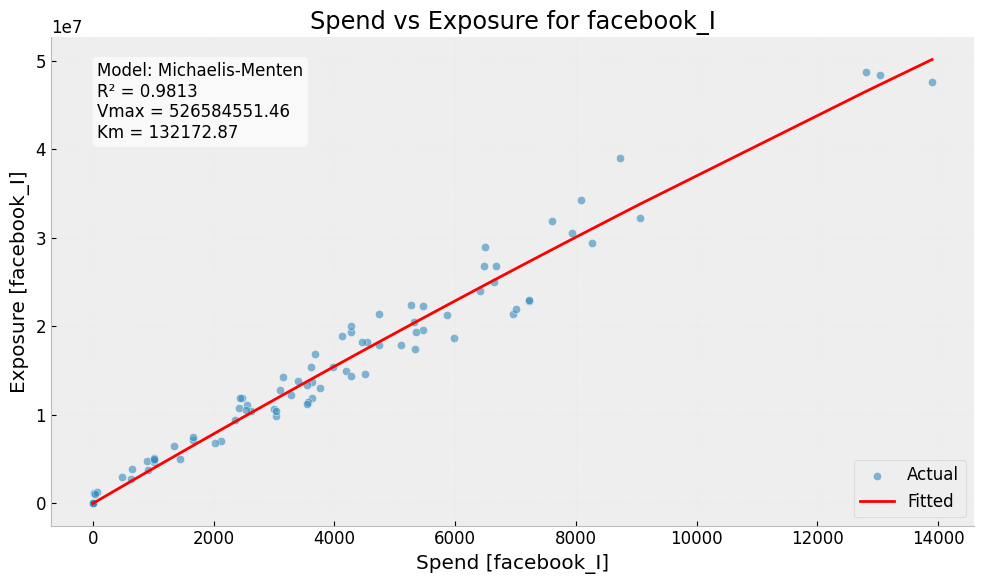

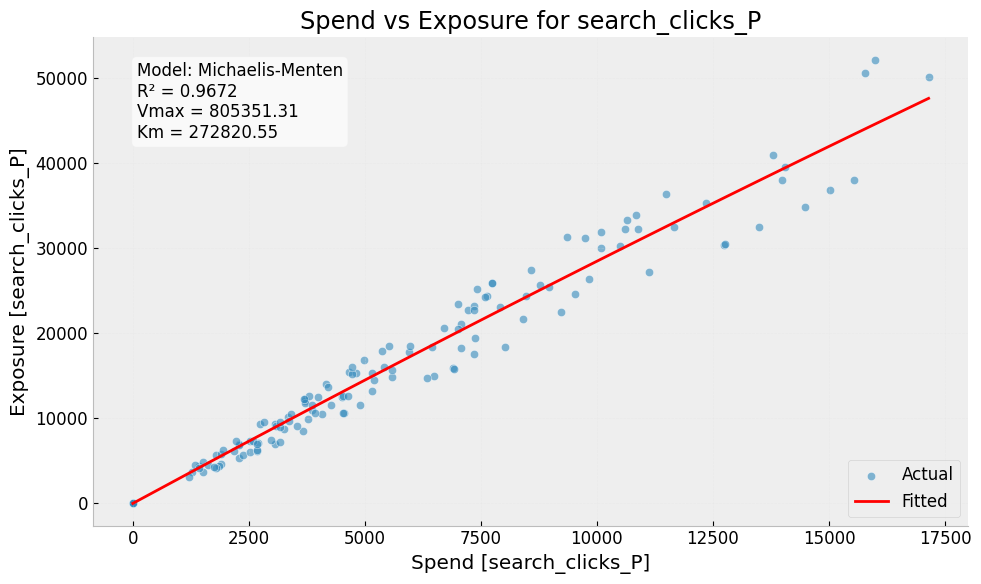

FeaturizedMMMData(dt_mod=            ds       dep_var         trend        season       holiday  \
0   2015-11-23  2.754372e+06  1.716264e+06  1.133548e+06       0.00000   
1   2015-11-30  2.584277e+06  1.717329e+06  8.990713e+05       0.00000   
2   2015-12-07  2.547387e+06  1.718393e+06  7.075011e+05       0.00000   
3   2015-12-14  2.875220e+06  1.719458e+06  6.933337e+05       0.00000   
4   2015-12-21  2.215953e+06  1.720523e+06  8.031644e+05  483714.32256   
..         ...           ...           ...           ...           ...   
203 2019-10-14  2.456240e+06  1.743483e+06  7.429261e+05       0.00000   
204 2019-10-21  2.182825e+06  1.742720e+06  7.979784e+05       0.00000   
205 2019-10-28  2.377707e+06  1.741957e+06  8.621816e+05       0.00000   
206 2019-11-04  2.732825e+06  1.741194e+06  1.003188e+06       0.00000   
207 2019-11-11  2.767788e+06  1.740432e+06  1.171096e+06       0.00000   

     competitor_sales_B events          tv_S          ooh_S       print_S  \
0        

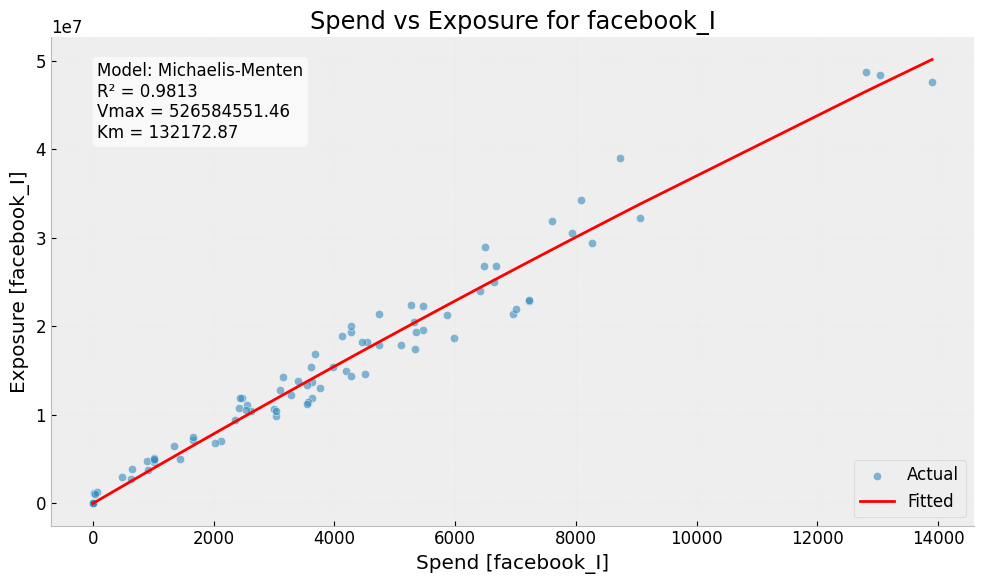

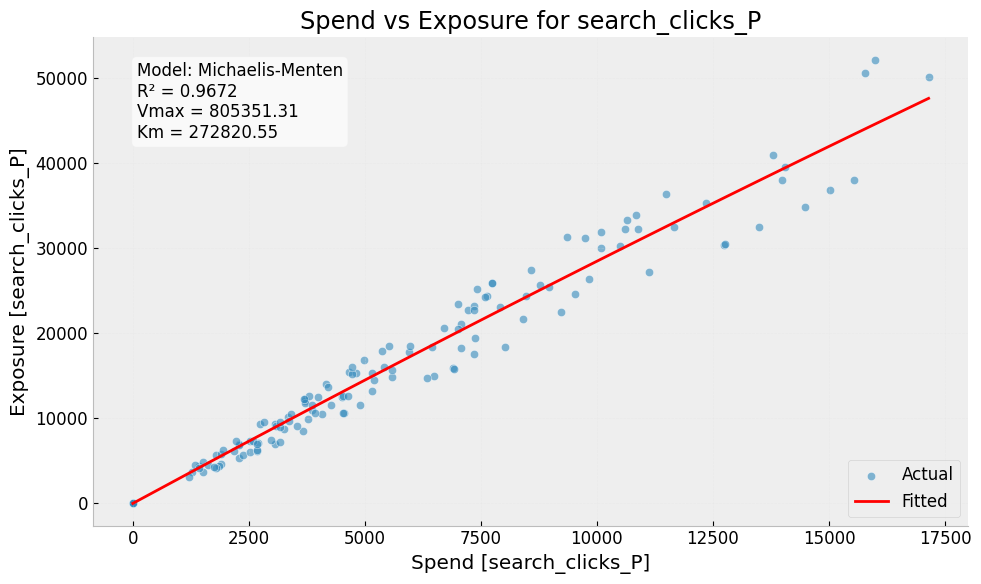

In [5]:
%matplotlib inline
robyn.feature_engineering()

## 3. Run Robyn Model

After initialization, we can run the Robyn model.

INFO: Training models
2024-11-18 13:28:07,231 - robyn.robyn - INFO - Training models
2024-11-18 13:28:07,233 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-18 13:28:07,233 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-18 13:28:07,233 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-18 13:28:07,234 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-18 13:28:07,234 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-18 13:28:07,234 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-18 13:28:07,235 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-18 13:28:07,235 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...
Running trial 1 of total 5 trials: 100%|

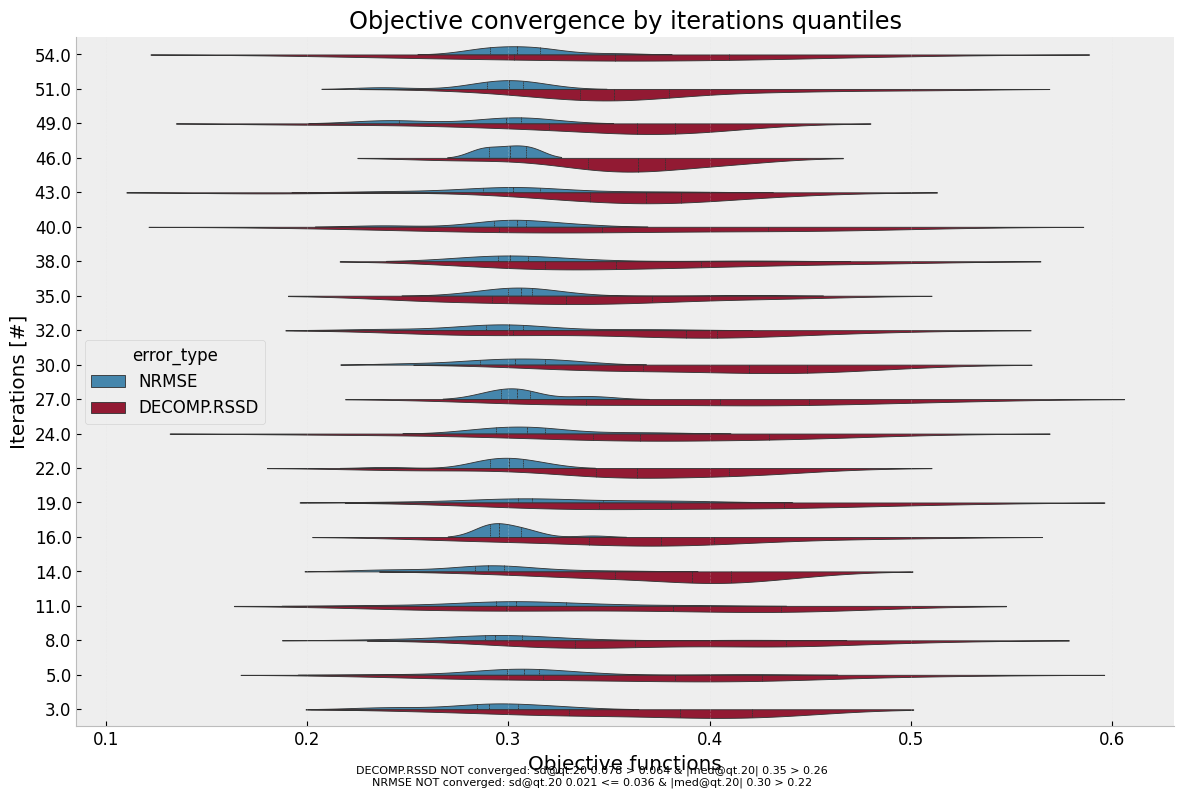

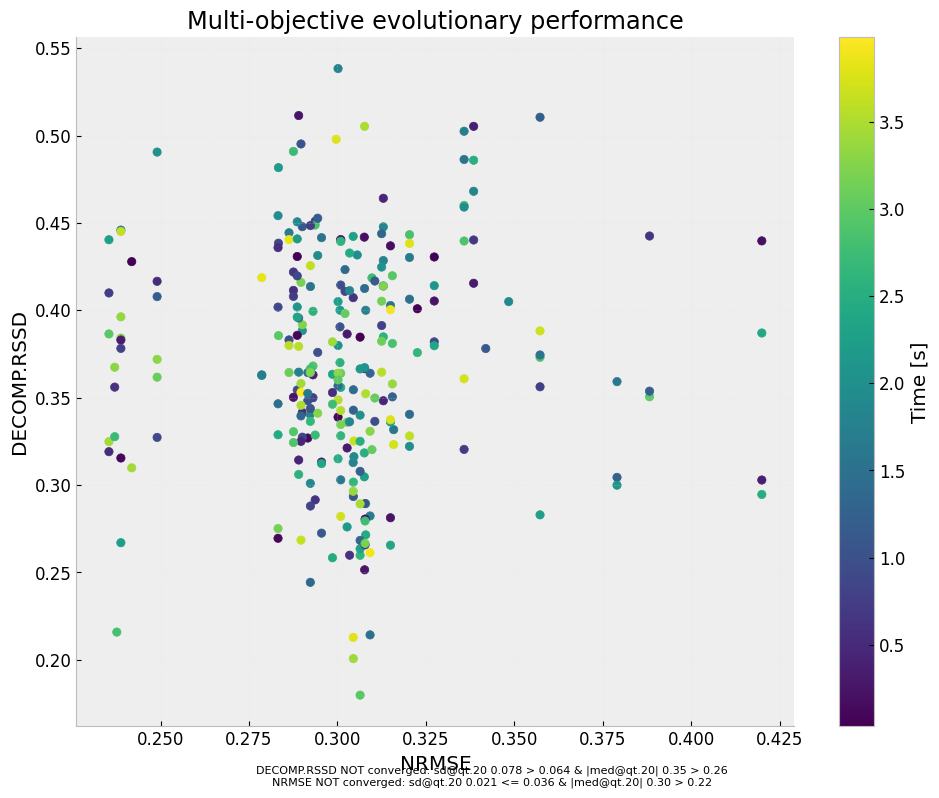

In [6]:
%matplotlib inline
from robyn.modeling.entities.enums import Models, NevergradAlgorithm
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig


trials_config = TrialsConfig(iterations=54, trials=5)

# Run the model
robyn.train_models(trials_config=trials_config,
                    ts_validation=True,  # changed from True to False -> deacitvate
                    add_penalty_factor=False,
                    cores=8,
                    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
                    model_name=Models.RIDGE,
                )

## Evaluate Models

INFO: Evaluating models
2024-11-18 13:28:27,850 - robyn.robyn - INFO - Evaluating models
2024-11-18 13:28:27 [INFO] Starting Pareto optimization
2024-11-18 13:28:27 [INFO] Starting model data aggregation
2024-11-18 13:28:27 [INFO] Computing Pareto fronts
2024-11-18 13:28:27 [INFO] Pareto front computation completed
2024-11-18 13:28:27 [INFO] Preparing Pareto data
2024-11-18 13:28:27 [INFO] Number of Pareto-optimal solutions found: 222
2024-11-18 13:28:27 [INFO] Selected 10 Pareto-fronts containing 110 candidates
2024-11-18 13:28:27 [INFO] Filtering data for selected Pareto fronts...
2024-11-18 13:28:27 [INFO] Calculating response curves for 550 models' media variables...
Processing rows: 100%|██████████| 550/550 [00:04<00:00, 122.65it/s]
2024-11-18 13:28:32 [INFO] Successfully processed 550 response curves
2024-11-18 13:28:32 [INFO] Computing final metrics...
2024-11-18 13:28:32 [INFO] Calculating ROI and CPA metrics...
2024-11-18 13:28:32 [INFO] Starting plot data generation...
2024-1

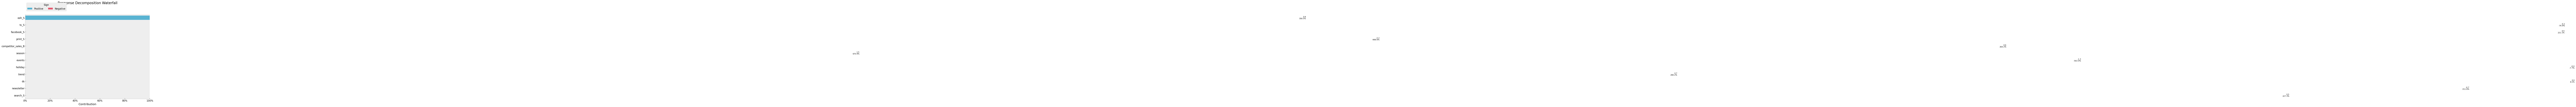

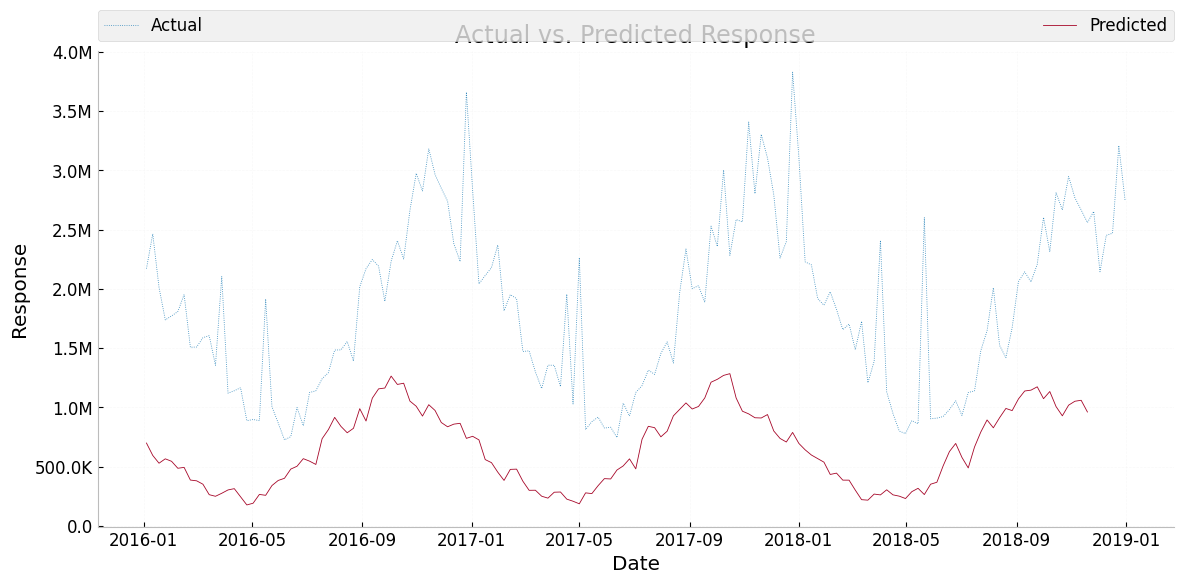

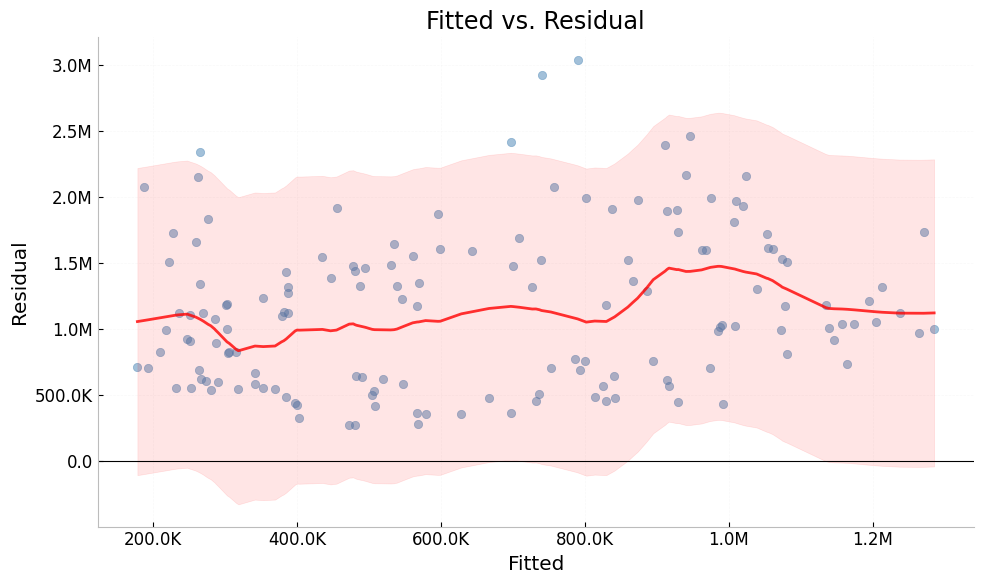

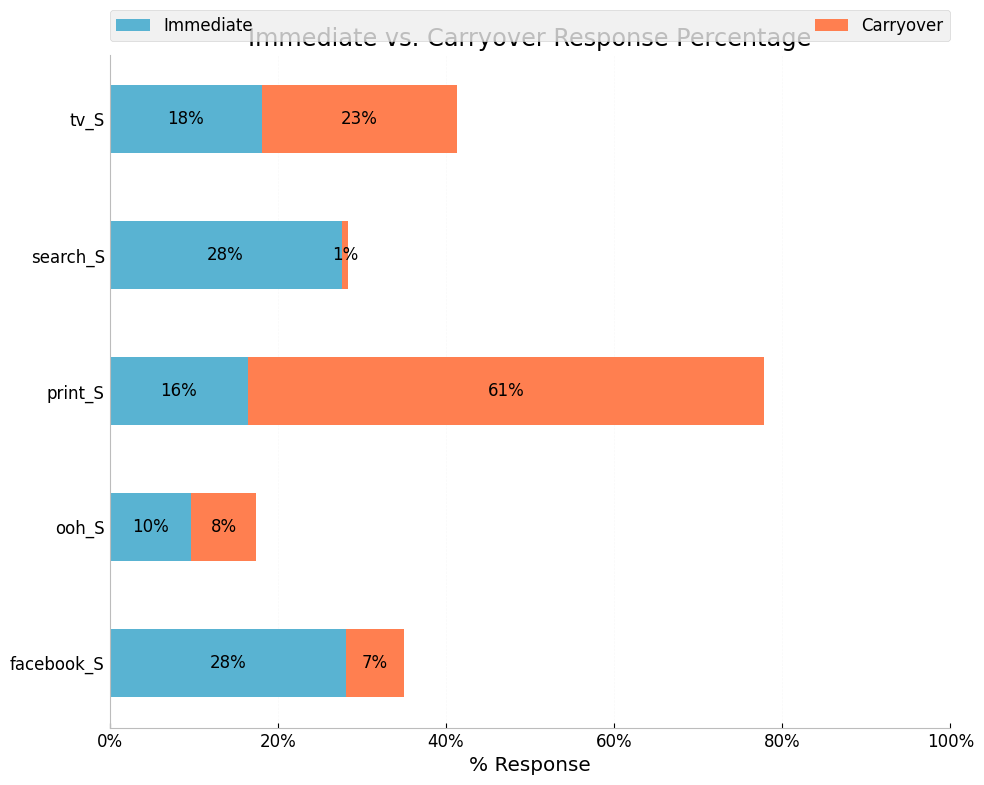

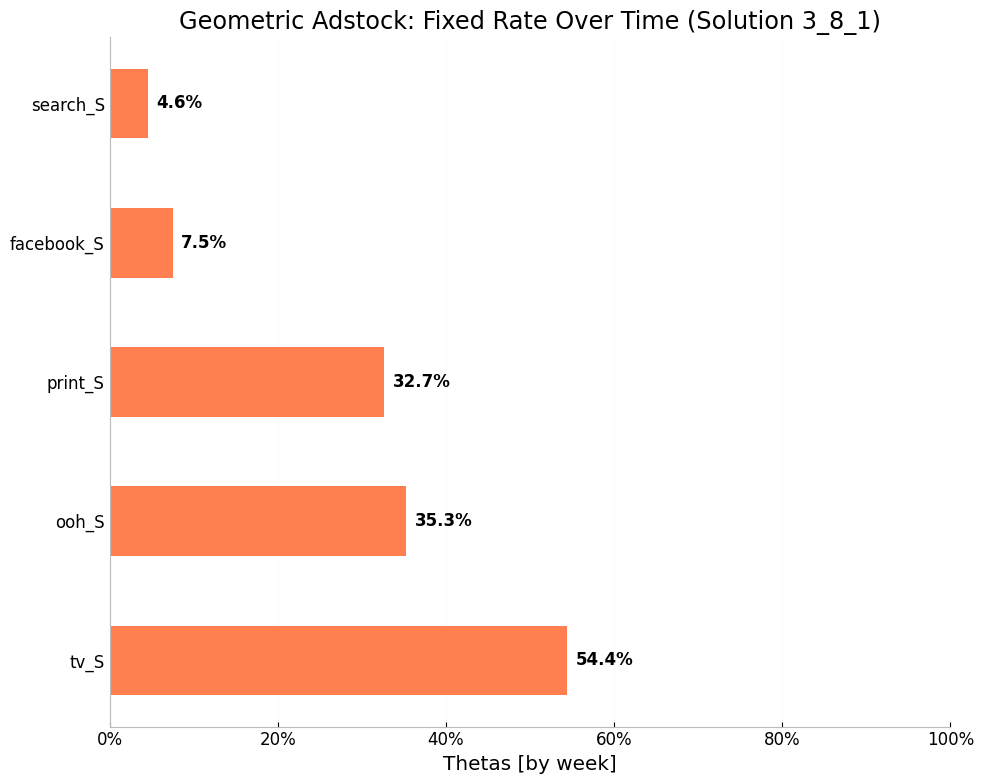

2024-11-18 13:28:44,024 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-18 13:28:44,024 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-18 13:28:44,024 - robyn.visualization.cluster_visualizer - WARNING - create_correlations_heatmap method is not implemented.


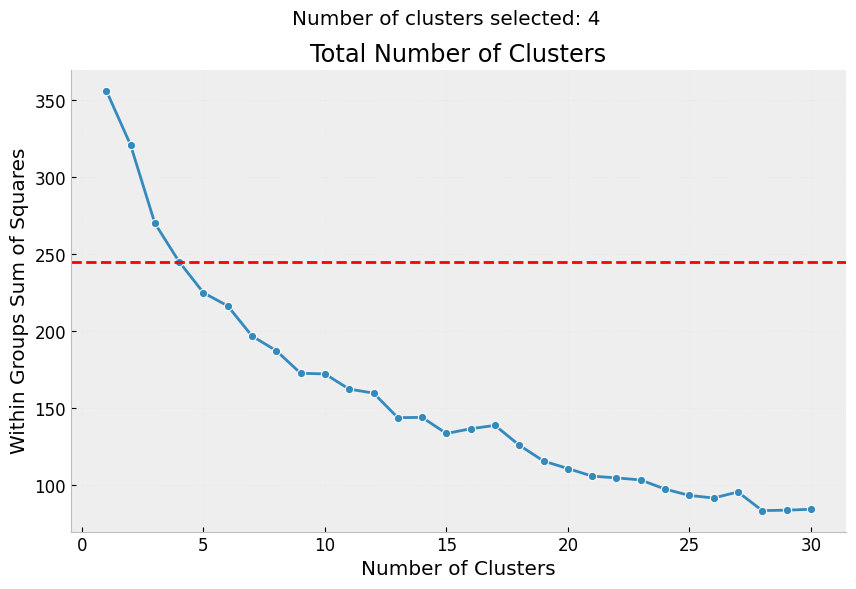

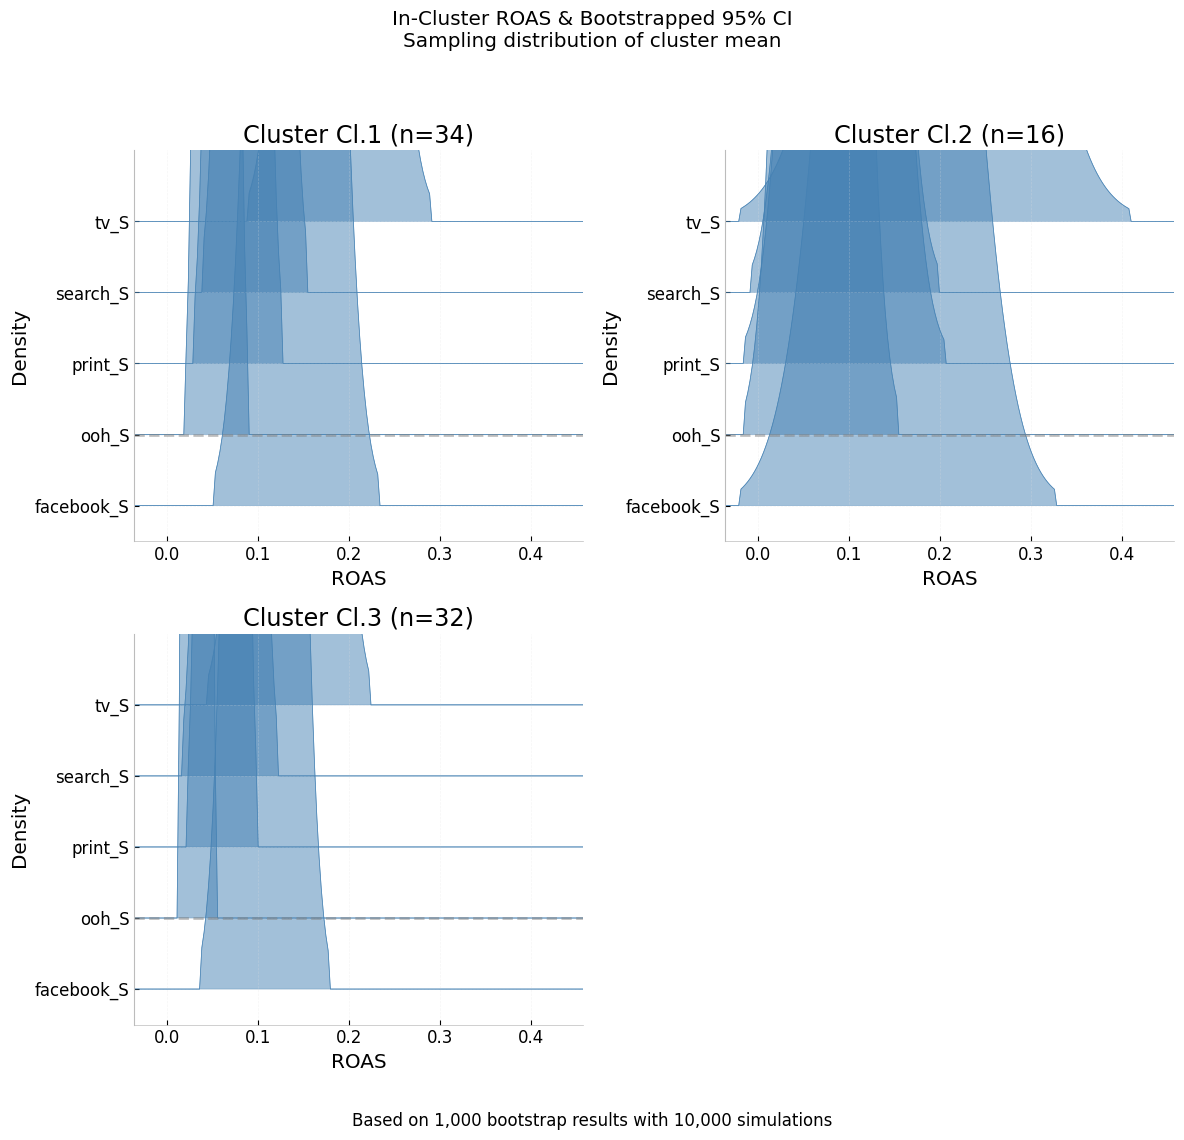

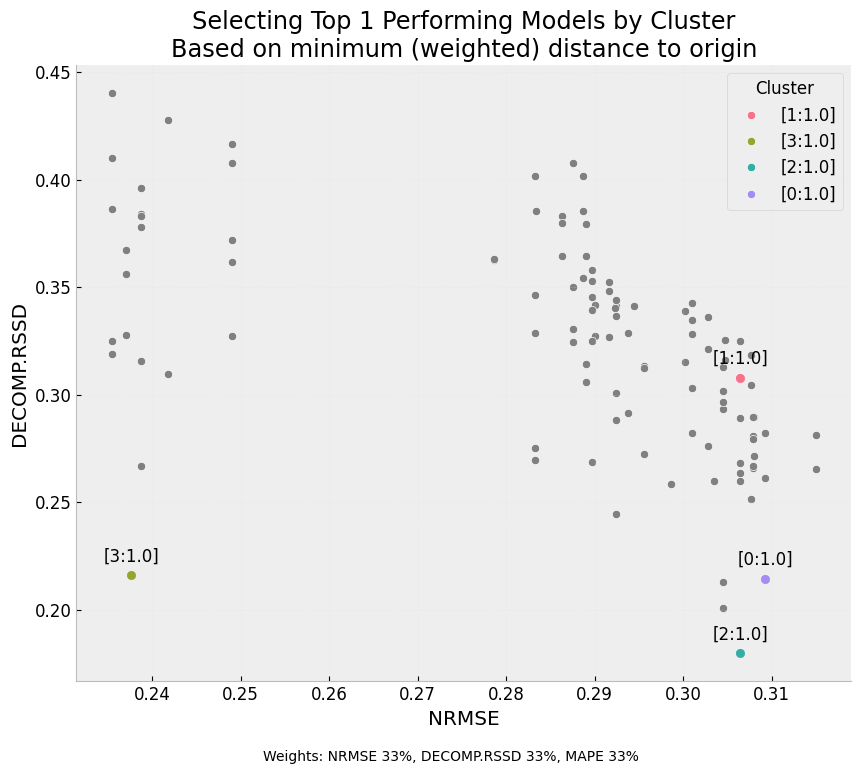

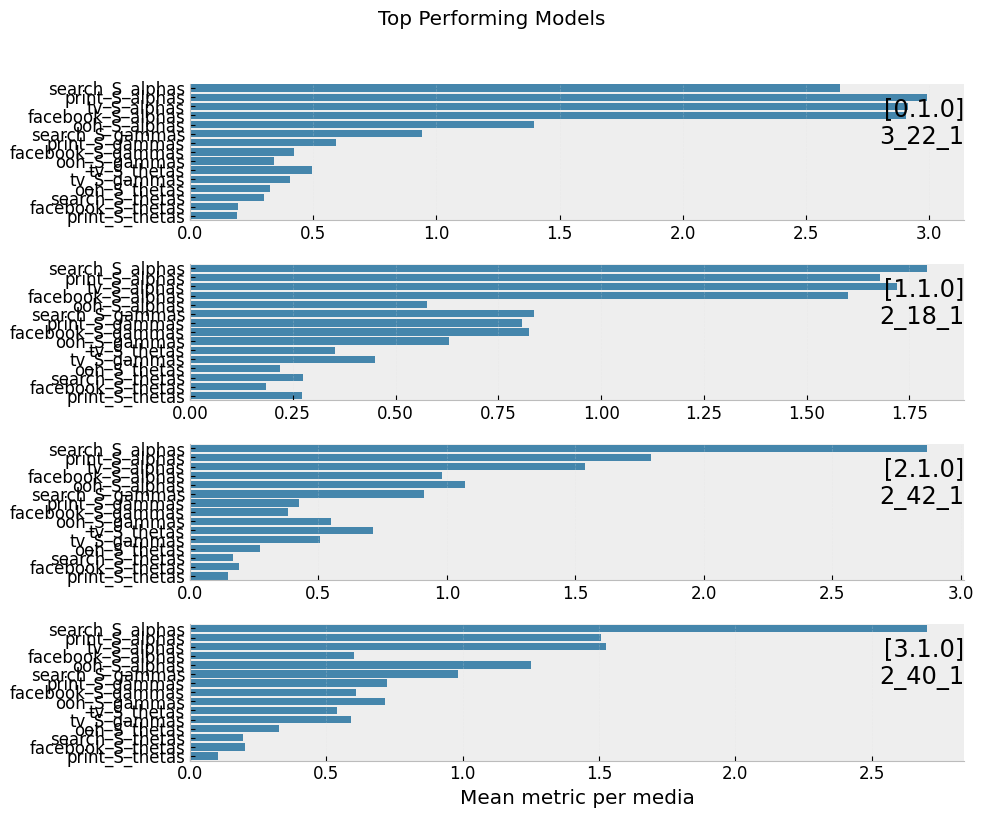

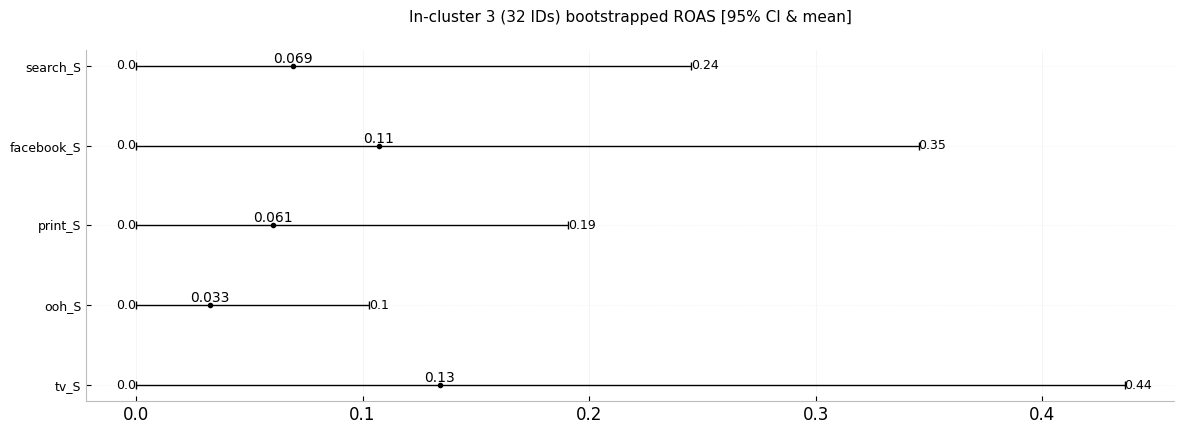

INFO: Model evaluation complete
2024-11-18 13:28:44,593 - robyn.robyn - INFO - Model evaluation complete


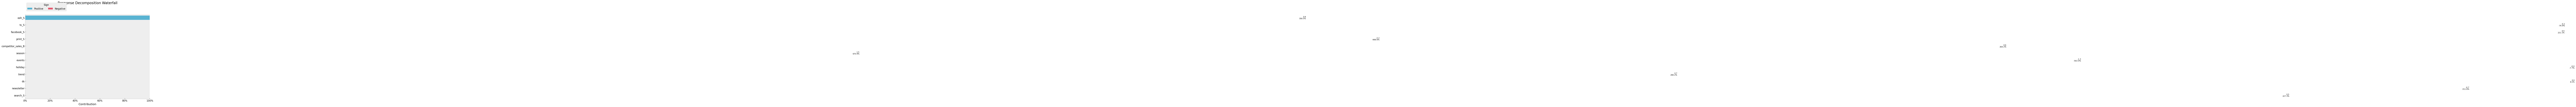

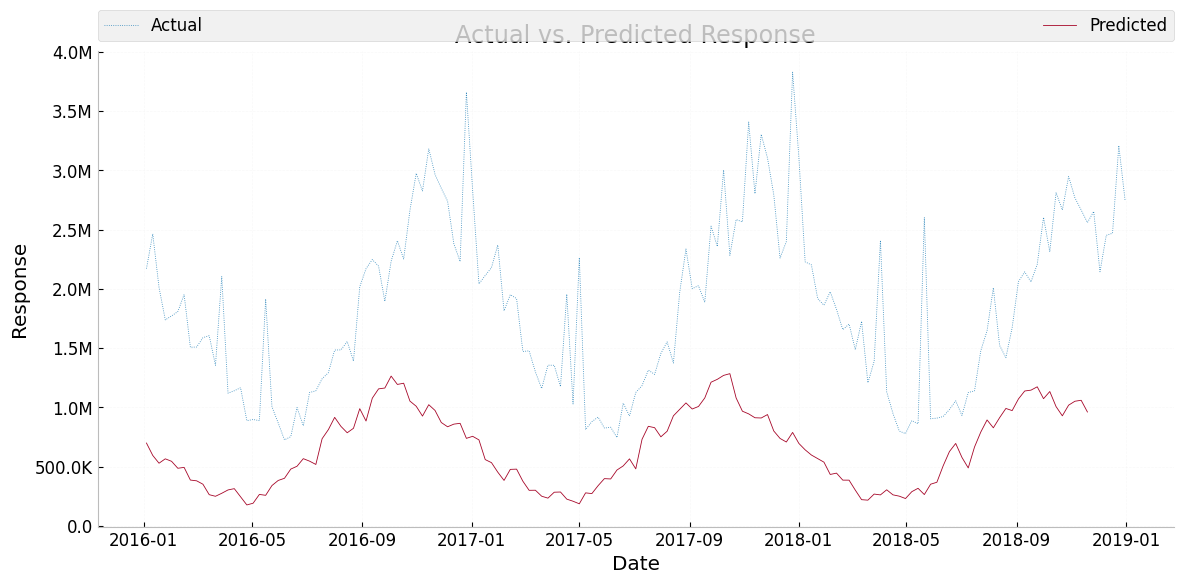

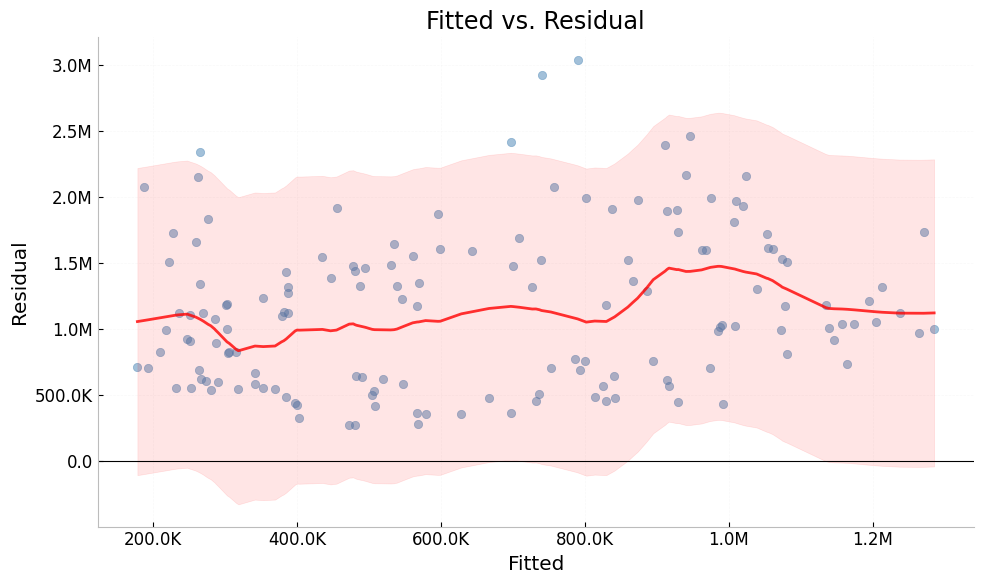

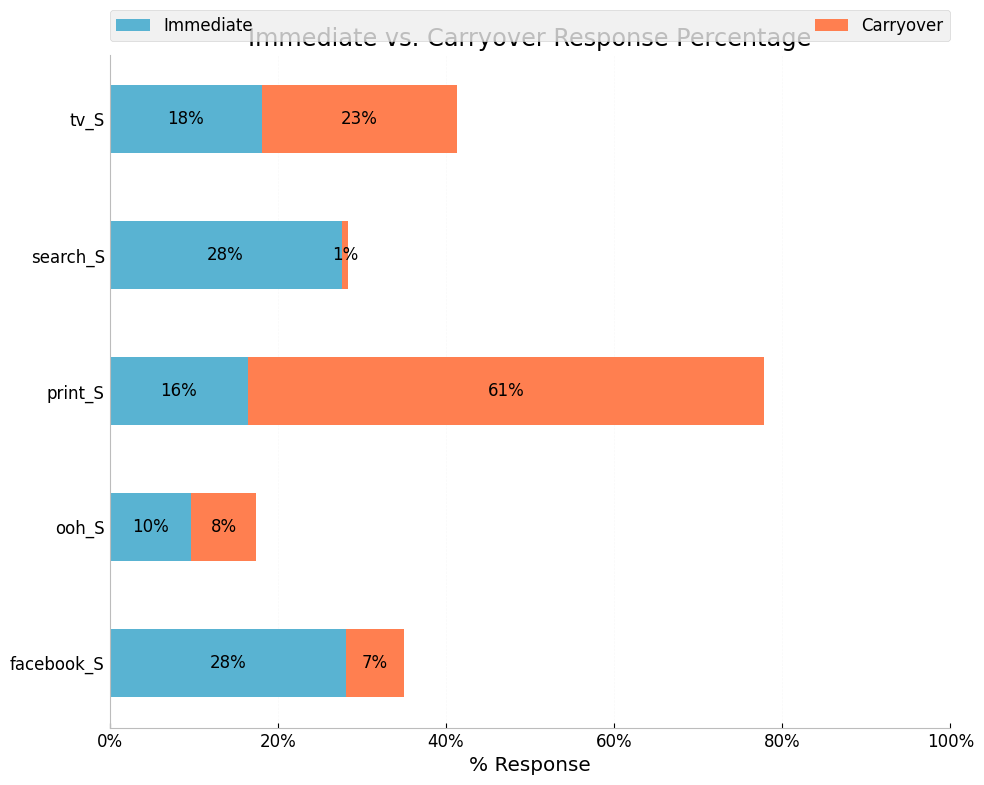

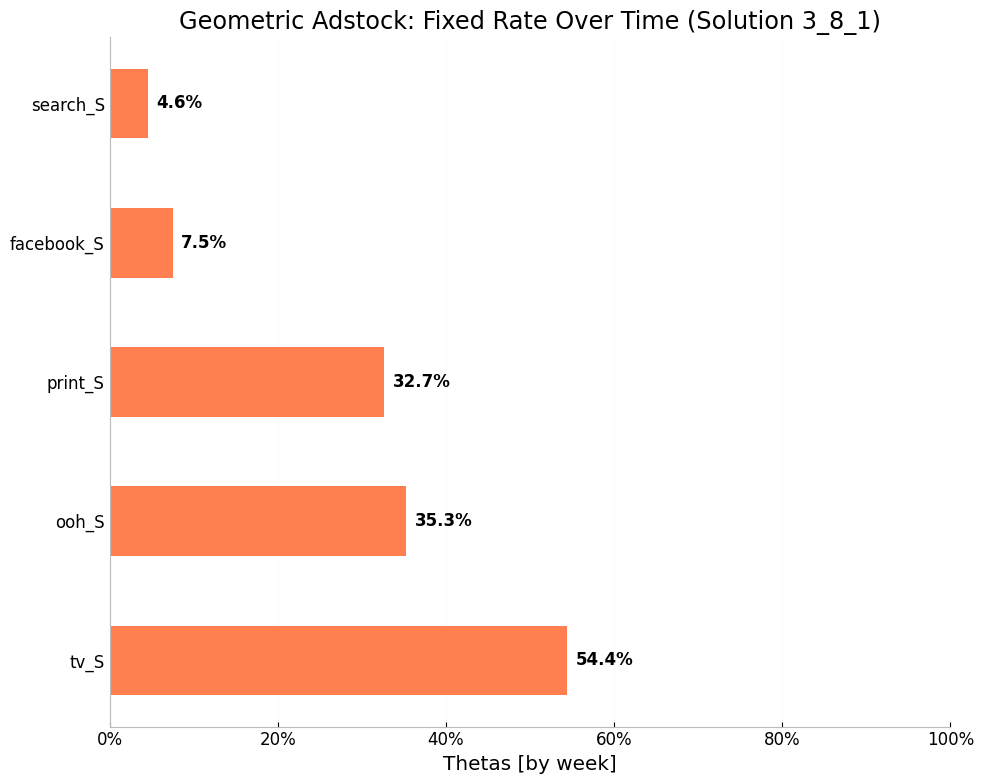

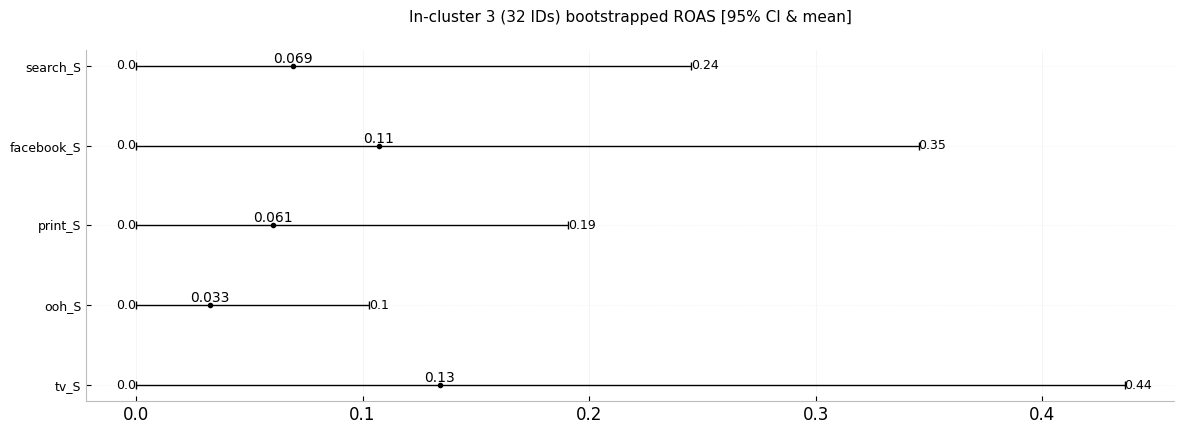

In [7]:
%matplotlib inline

from robyn.modeling.clustering.clustering_config import ClusterBy, ClusteringConfig


configs = ClusteringConfig(
    dep_var_type= DependentVarType(mmm_data.mmmdata_spec.dep_var_type),
    cluster_by = ClusterBy.HYPERPARAMETERS,
    max_clusters = 10,
    min_clusters = 3,
    weights=[1.0, 1.0, 1.0]
)
robyn.evaluate_models(cluster_config=configs)

## 4. Budget Allocation

Finally, let's perform budget allocation using the trained model.

This notebook demonstrates the basic workflow of using Robyn for Marketing Mix Modeling. In a real-world scenario, you would need to replace the synthetic data with your actual marketing data and adjust the parameters accordingly.

Remember to explore the full capabilities of Robyn, including model evaluation, visualization, and interpretation of results, which are beyond the scope of this basic demonstration.

INFO: Optimizing budget allocation
2024-11-18 13:28:45,852 - robyn.robyn - INFO - Optimizing budget allocation
2024-11-18 13:28:45,853 - robyn.allocator.budget_allocator - INFO - Initializing BudgetAllocator
2024-11-18 13:28:45,855 - robyn.allocator.media_response - INFO - Initializing MediaResponseParamsCalculator
2024-11-18 13:28:45,855 - robyn.allocator.allocation_optimizer - INFO - Initializing AllocationOptimizer
2024-11-18 13:28:45,862 - robyn.allocator.media_response - INFO - Starting media response parameters calculation for model 3_8_1


2024-11-18 13:28:45,884 - robyn.allocator.media_response - INFO - Successfully calculated media response parameters: MediaResponseParameters(alphas=5 channels, inflexions=5 channels, coefficients=5 channels)
2024-11-18 13:28:45,886 - robyn.allocator.budget_allocator - INFO - BudgetAllocator initialization completed successfully
2024-11-18 13:28:45,886 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-18 13:28:45,888 - robyn.allocator.budget_allocator - WARNING - Found zero mean spend for channels: ['tv_S' 'ooh_S' 'print_S' 'search_S']
2024-11-18 13:28:45,893 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 13:28:45,894 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 13:28:45,907 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-18 13:28:45,915 - robyn.allocator.response_calculato

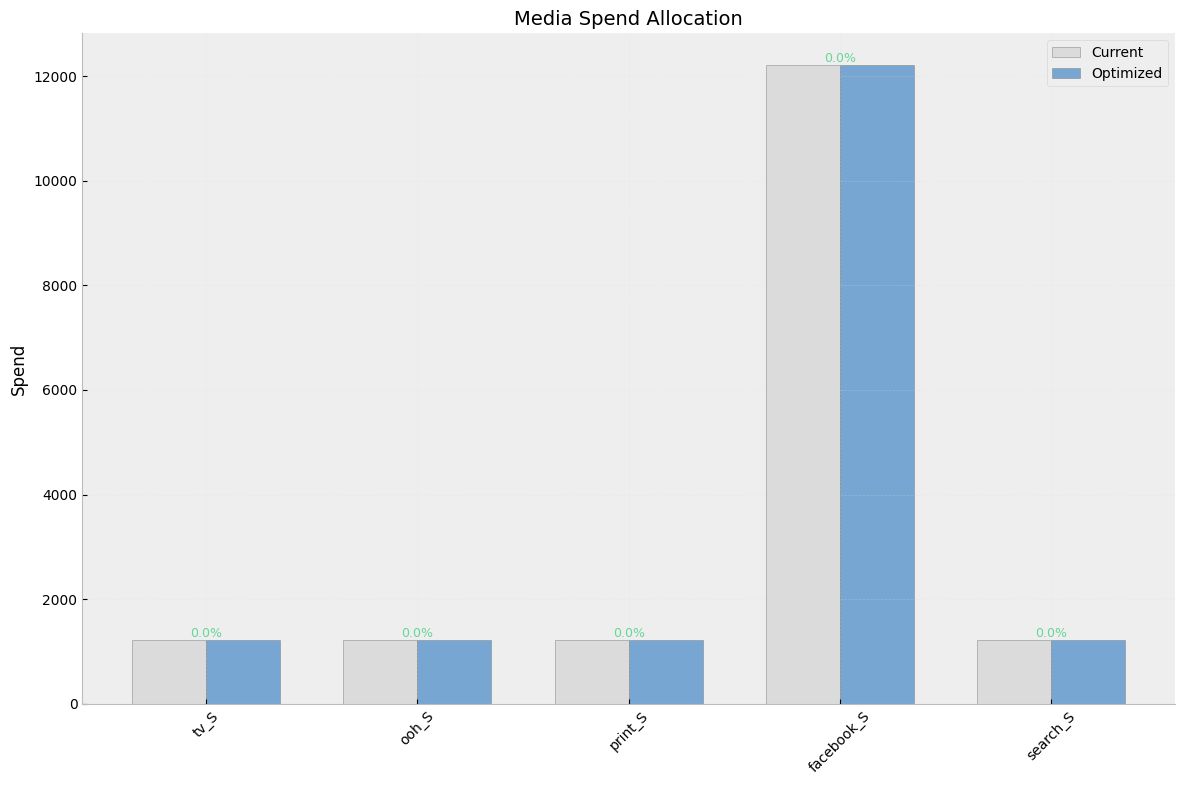

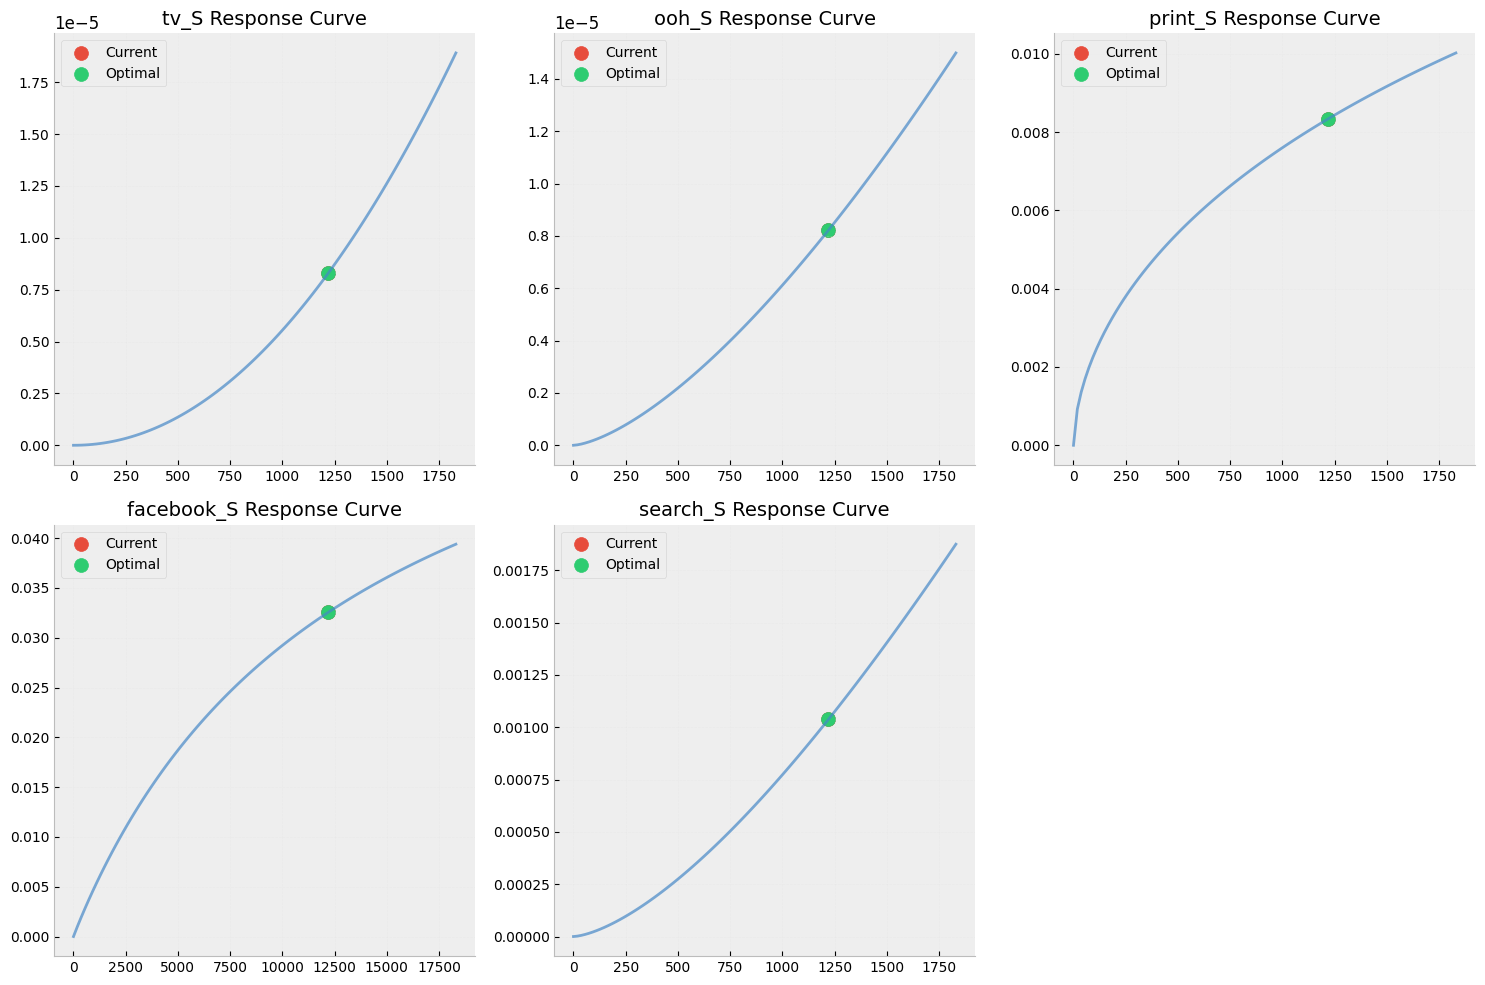

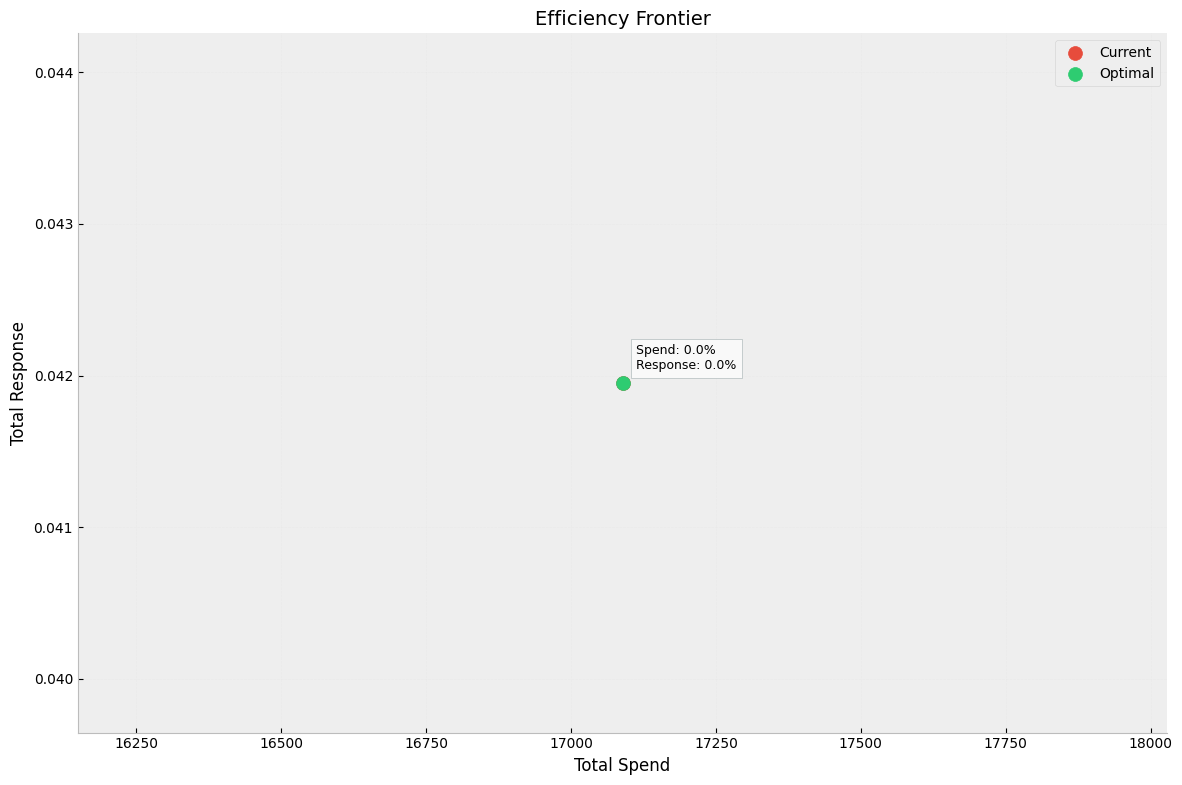

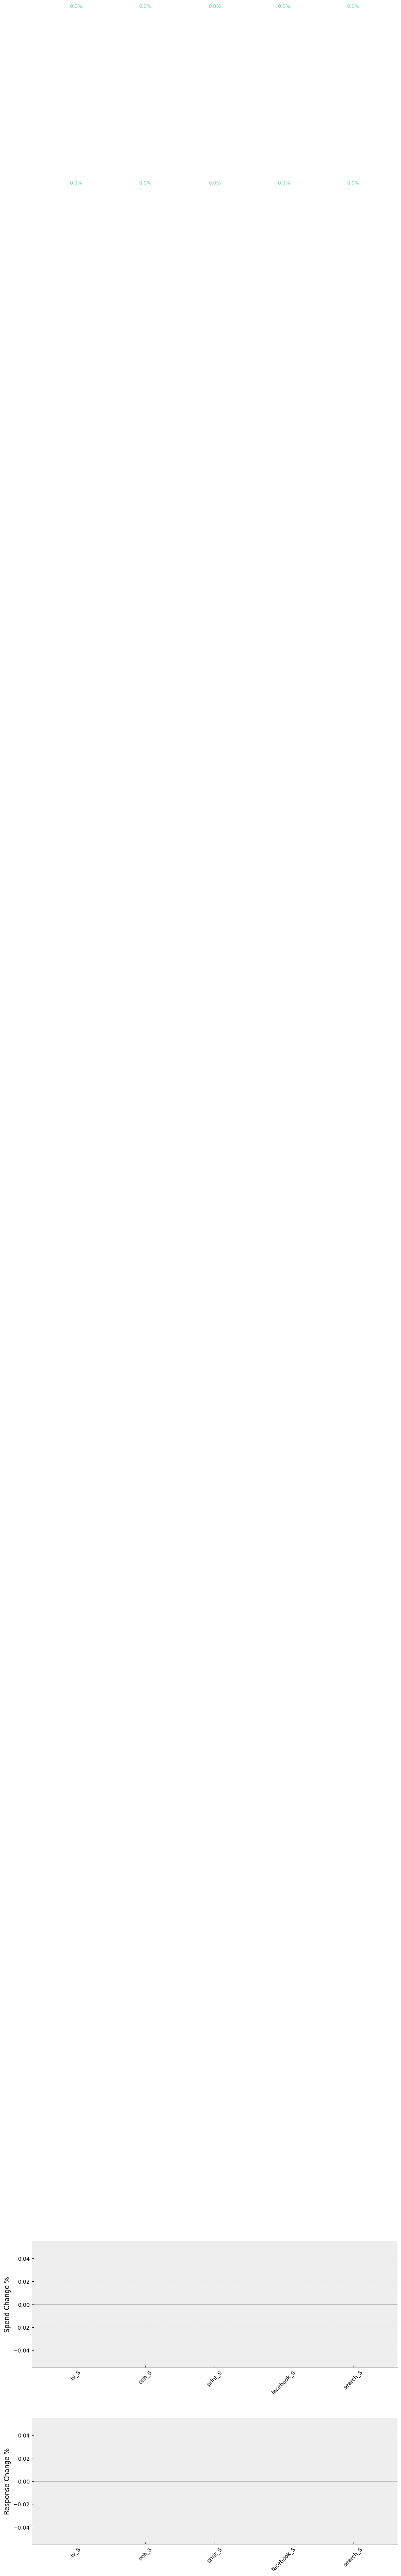

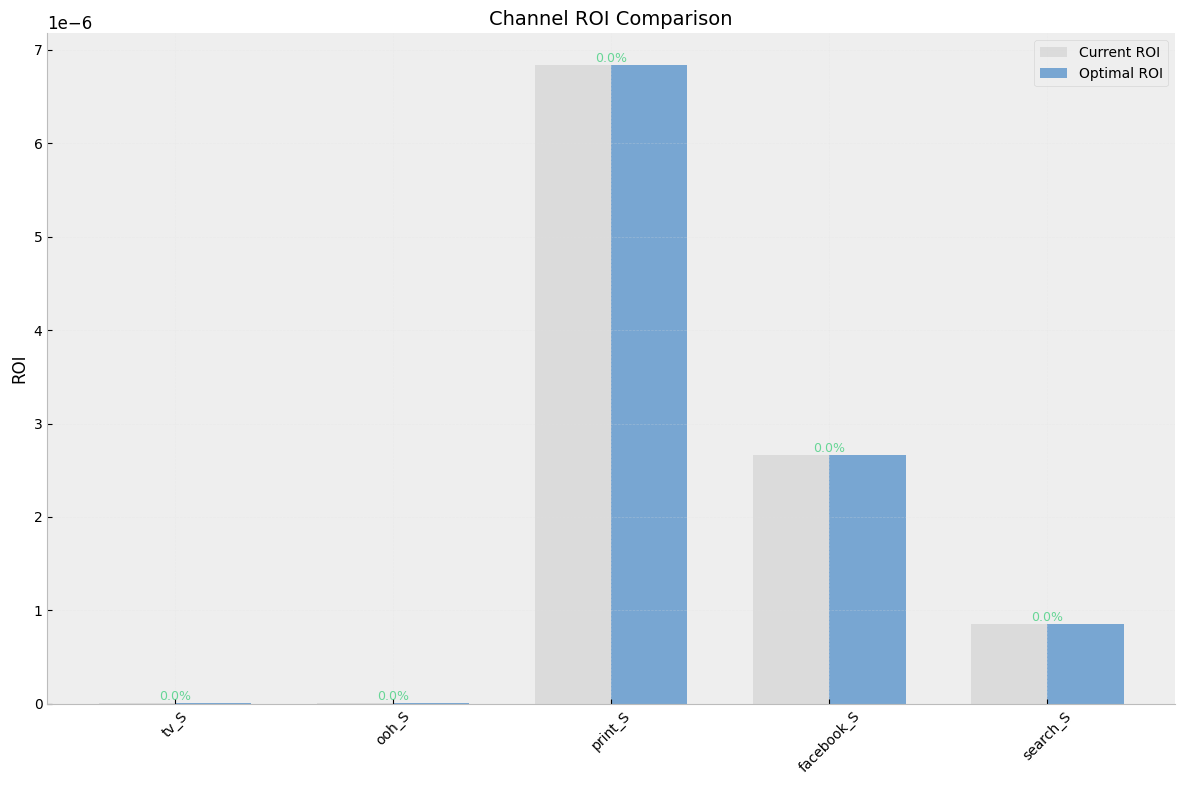

INFO: Budget optimization complete
2024-11-18 13:28:47,117 - robyn.robyn - INFO - Budget optimization complete


AllocationResult(
Total Current Spend: $17,088.90
Total Optimal Spend: $17,088.90
Spend Lift: +0.0%
Response Lift: +0.0%)


In [8]:
%matplotlib inline
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode

# Define allocation constraints
channel_constraints = AllocationConstraints(
    channel_constr_low={
        "tv_S": 0.7,  # -30% from base
        "ooh_S": 0.7,
        "print_S": 0.7,
        "facebook_S": 0.7,
        "search_S": 0.7,
    },
    channel_constr_up={
        "tv_S": 1.2,  # +20% from base
        "ooh_S": 1.5,  # +50% from base
        "print_S": 1.5,
        "facebook_S": 1.5,
        "search_S": 1.5,
    },
    channel_constr_multiplier=3.0,
)
# Configure allocation scenario
allocation_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
)

# Call the budget_allocator method
allocation_result = robyn.optimize_budget(
    allocation_config=allocation_config,
    select_model=None,
)
# Display the allocation result
print(allocation_result)

## Robyn One Pager Report

In [9]:
#robyn.generate_one_pager()